In [85]:
import scipy.io
import numpy as np

import pandas as pd
# pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import copy
import random
import math
import scipy
import time

from scipy.optimize import minimize
from numba import jit, njit

# people.uncw.edu/hermanr/latex

In [90]:
group = "senate"
dataframe_mat = scipy.io.loadmat(f"Data/processed data_{group}.mat")

In [87]:
vote_rc = pd.DataFrame(
    data = dataframe_mat['V_rc'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['V_rc']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['V_rc'][0]))] # 1st row as the column names
)
leader_rc = pd.DataFrame(
    data = dataframe_mat['leader_rc'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['leader_rc']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['leader_rc'][0]))] # 1st row as the column names
)
whip_rc = pd.DataFrame(
    data = dataframe_mat['whip_rc'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['whip_rc']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['whip_rc'][0]))] # 1st row as the column names
)
bigmajority_list = pd.DataFrame(
    data = dataframe_mat['bigmajority_list'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['bigmajority_list']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['bigmajority_list'][0]))] # 1st row as the column names
)
party_list = pd.DataFrame(
    data = dataframe_mat['party_list'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['party_list']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['party_list'][0]))] # 1st row as the column names
)
congress_list = pd.DataFrame(
    data = dataframe_mat['congress_list'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['congress_list']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['congress_list'][0]))] # 1st row as the column names
)

### 1. Data Preproccessing

In [86]:
print(f"{group.upper()} statistics")
print("----------------")

congress_id, bills_per_congress = np.unique(congress_list.values, return_counts=True)
print(f"\nNumber of bills overall = {np.sum(bills_per_congress)} ({len(congress_id)} congresses, id: {np.min(congress_id)} - {np.max(congress_id)})")
print(f"Number of deputies overall = {party_list.size}")

congress_id_involved = 71
print(f"\nCongress id involved: {congress_id_involved}")

beginning_bills_in_congresses_involved = bills_per_congress[
    0:int(congress_id_involved - np.min(congress_id))
].sum()
ending_bills_in_congresses_involved = bills_per_congress[
    0:int(congress_id_involved - np.min(congress_id) + 1)
].sum()

vote_congress = vote_rc.iloc[:,beginning_bills_in_congresses_involved:ending_bills_in_congresses_involved].dropna(how='all')
vote_congress_array = np.array(vote_congress)

party_list_congress = party_list.loc[vote_congress.index]
party_list_congress_array = np.array(party_list_congress).flatten()

bigmajority_list_congress = bigmajority_list.loc[:,vote_congress.columns]
bigmajority_list_congress = pd.concat([bigmajority_list_congress]*len(vote_congress.index))
bigmajority_list_congress.index = vote_congress.index
bigmajority_list_congress_array = np.array(bigmajority_list_congress).flatten()

leader_rc_congress = leader_rc.loc[vote_congress.index,vote_congress.columns]
leader_rc_congress_array = np.array(leader_rc_congress)

whip_rc_congress = whip_rc.loc[vote_congress.index,vote_congress.columns]
whip_rc_congress_array = np.array(whip_rc_congress)

N = vote_congress.shape[0]
T = vote_congress.shape[1]

print(f"Number of bills in the congress = {T}")
print(f"Number of deputies in the congress = {N}")

SENATE statistics
----------------

Number of bills overall = 25825 (46 congresses, id: 70 - 115)
Number of deputies overall = 805

Congress id involved: 71
Number of bills in the congress = 436
Number of deputies in the congress = 108


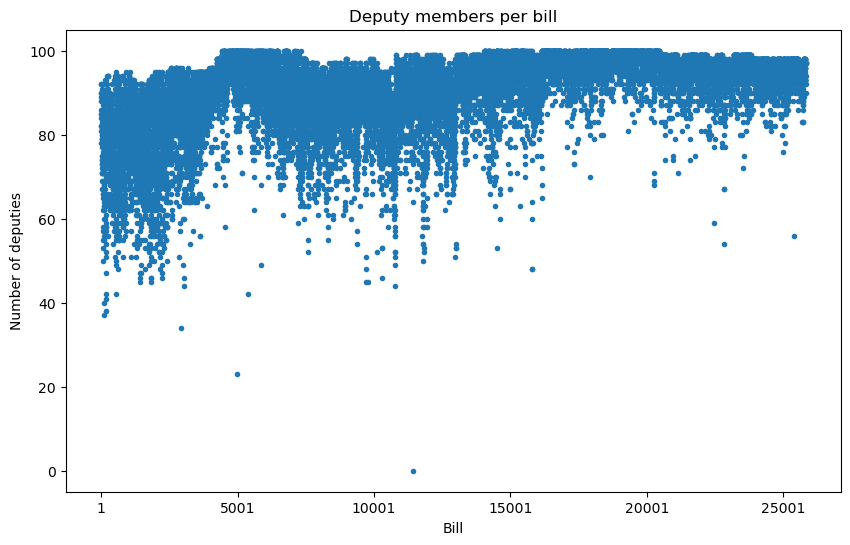

In [89]:
plt.figure(figsize=(10,6))
vote_rc.notna().sum().plot(title="Deputy members per bill", style=".", xlabel="Bill", ylabel="Number of deputies")
plt.show()

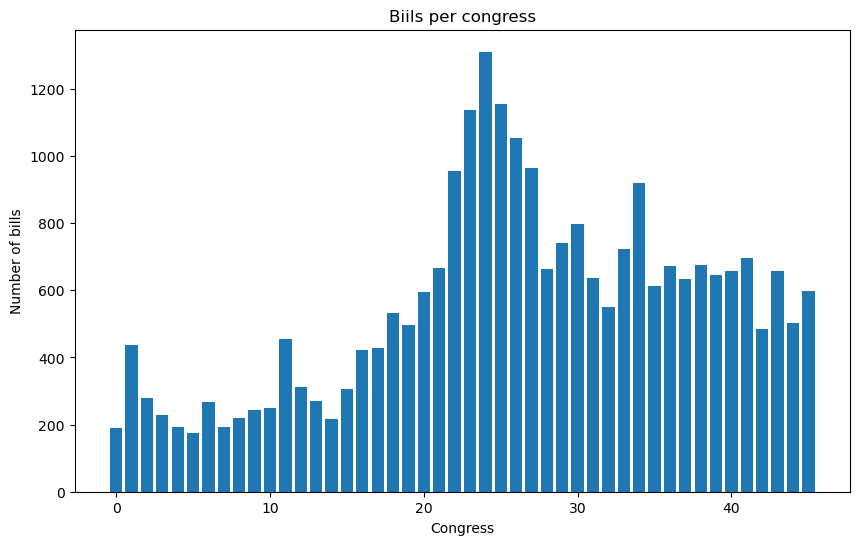

In [88]:
plt.figure(figsize=(10,6))
plt.bar(x=np.arange(0,len(bills_per_congress)), height=bills_per_congress)
plt.xlabel("Congress")
plt.ylabel("Number of bills")
plt.title("Biils per congress")
plt.show()

In [91]:
party_direction_congress = copy.deepcopy(leader_rc_congress)

print(f"Nans in party_direction: {party_direction_congress.isnull().sum().sum()}/{party_direction_congress.size}")

party_direction_congress.fillna(whip_rc_congress, inplace=True)
party_direction_congress.fillna(bigmajority_list_congress, inplace=True)

print(f"Nans after fillna: {party_direction_congress.isnull().sum().sum()}/{party_direction_congress.size}")

party_direction_congress_array = np.array(party_direction_congress)

Nans in party_direction: 5803/47088
Nans after fillna: 0/47088


### 2. Initial Guess

In [95]:
random.seed(112)

theta = np.array([[random.uniform(0,1),random.uniform(0,1)] for _ in range(N)])

# Normalize theta
theta = theta - theta[0]

# center Dems around 0 and GOP further right
theta[1:] = [
	theta[i] - 0.5 if party_list_congress_array[i] == 100 else theta[i] + 0.5 
	for i in range(1,len(theta))
]

# initialize ymax
ymax = np.array([random.uniform(0,1), random.uniform(0,1)])

# initialize cutlines for bills
m = np.array([1 - 2*random.uniform(0,1) for _ in range(T)])
b = np.array([1 - 2*random.uniform(0,1) for _ in range(T)])

# construct a big parameter vector
omega_initial_guess = np.concatenate([theta.flatten(), ymax, m, b])

print(f"Parameters of the model: {len(omega_initial_guess)}")

Parameters of the model: 1090


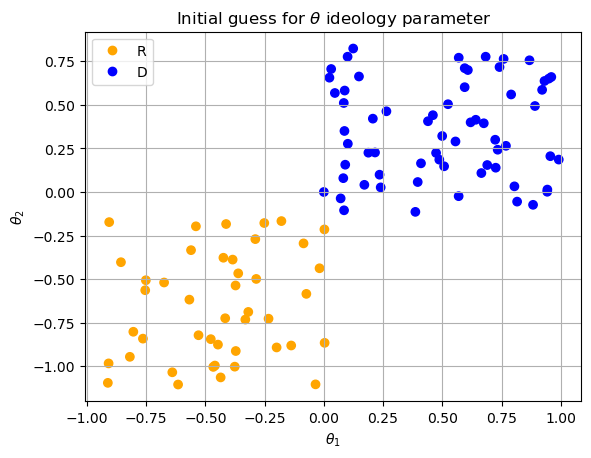

In [92]:
scatter = plt.scatter(
    x = [omega_initial_guess[0 + 2*deputy] for deputy in range(N)], 
    y = [omega_initial_guess[1 + 2*deputy] for deputy in range(N)],
    c = party_list_congress_array,
    cmap = ListedColormap(["orange","blue"])
)
plt.legend(handles=scatter.legend_elements()[0], labels=["R","D"])
plt.grid()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title(r"Initial guess for $\theta$ ideology parameter")
plt.show()

### 3. Likelihood Optimization

In [93]:
@njit
def norm_cdf(x):
    # Cumulative distribution function for the standard normal distribution
    return (1.0 + math.erf(x / np.sqrt(2.0))) / 2.0

In [99]:
@njit
def likelihood(omega):
	# Unpack (decompose) parameter vector
	theta = np.zeros((N,2))
	ymax = np.zeros(2)
	m = np.zeros(T)
	b = np.zeros(T)

	for deputy in range(N):
		theta[deputy][0], theta[deputy][1] = omega[0 + 2*deputy], omega[1 + 2*deputy]

	ymax[0], ymax[1] = omega[0 + 2*N], omega[1 + 2*N]

	for bill in range(T):
		m[bill], b[bill] = omega[2*N + 2 + bill], omega[2*N + 2 + T + bill]
  
	# Calculate likelihood value
	likelihood_value = 0

	for bill in range(T):
		for deputy in np.where(~np.isnan(vote_congress_array.T[bill]))[0]:
			whip_party = int(not(
				bool(vote_congress_array[deputy][bill]) ^ bool(party_direction_congress_array[deputy][bill])
			))
			party_id = int(bool(party_list_congress_array[deputy] - 100)) # R for 1 (200), D for 0 (100)
			
			cdf_arg = np.sqrt(1 / (1 + m[bill]**2)) * (
				theta[deputy][1] - m[bill]*theta[deputy][0] - b[bill] + whip_party*ymax[party_id]
			)
			
			cdf_value_arg = norm_cdf(cdf_arg)
			cdf_value_neg_arg = norm_cdf(-cdf_arg)

			likelihood_0 = vote_congress_array[deputy][bill] * np.log(cdf_value_arg) + \
				(1 - vote_congress_array[deputy][bill]) * np.log(1 - cdf_value_arg)
			likelihood_1 = vote_congress_array[deputy][bill] * np.log(cdf_value_neg_arg) + \
				(1 - vote_congress_array[deputy][bill]) * np.log(1 - cdf_value_neg_arg)
			if likelihood_0 >= likelihood_1:
				likelihood_value += likelihood_0
			else:
				likelihood_value += likelihood_1

	return likelihood_value

In [94]:
# Run to turn on @njit (time-consuming)
likelihood(omega_initial_guess)

start_time = time.time()
likelihood(omega_initial_guess)
end_time = time.time()
print(f"Time of one execution = {round(end_time-start_time,4)} s")

Time of one execution = 0.0044 s


In [96]:
result = minimize(
	fun = lambda omega: -likelihood(omega),
	x0 = omega_initial_guess,
	method = "SLSQP", # "SLSQP", "Nelder-Mead"
)

In [100]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 19.34093464842809
       x: [-6.238e-01  6.217e+00 ...  9.450e-03  3.317e-01]
     nit: 38
     jac: [-8.465e-02 -2.320e-01 ...  4.182e-02  3.120e-02]
    nfev: 41567
    njev: 38

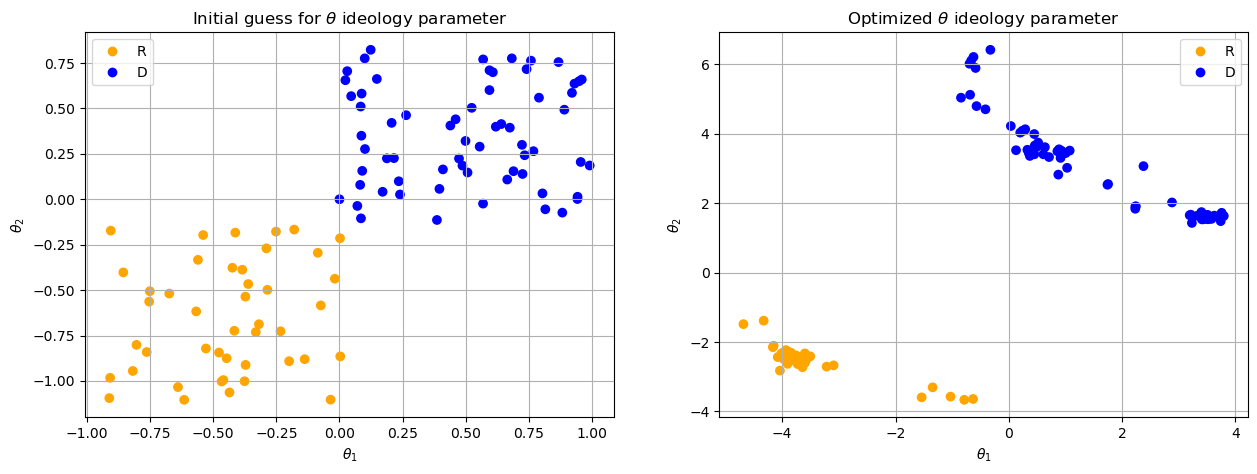

In [101]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
scatter = plt.scatter(
    x = [omega_initial_guess[0 + 2*deputy] for deputy in range(N)], 
    y = [omega_initial_guess[1 + 2*deputy] for deputy in range(N)],
    c = party_list_congress_array,
    cmap = ListedColormap(["orange","blue"])
)
plt.legend(handles=scatter.legend_elements()[0], labels=["R","D"])
plt.grid()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title(r"Initial guess for $\theta$ ideology parameter")

omega_hat = result.x
theta_1_R = [omega_hat[0 + 2*deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100]
theta_2_R = [omega_hat[1 + 2*deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100]
R_party_centroid = np.array([np.mean(theta_1_R),np.mean(theta_2_R)])

theta_1_D = [omega_hat[0 + 2*deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200]
theta_2_D = [omega_hat[1 + 2*deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200]
D_party_centroid = np.array([np.mean(theta_1_D),np.mean(theta_2_D)])

distance_between_party_centroids = np.sqrt(np.sum(np.square(R_party_centroid - D_party_centroid)))

plt.subplot(1,2,2)
scatter = plt.scatter(
    x = [omega_hat[0 + 2*deputy] for deputy in range(N)], 
    y = [omega_hat[1 + 2*deputy] for deputy in range(N)],
    c = party_list_congress_array,
    cmap = ListedColormap(["orange","blue"])
)
plt.legend(handles=scatter.legend_elements()[0], labels=["R","D"])
plt.grid()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title(r"Optimized $\theta$ ideology parameter")

plt.show()